In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Phase 2 strategies
# -------------------------------
from phase_2.scripts.strategies.trend.trend_strategy_v1 import run_trend_strategy_v1
from phase_2.scripts.strategies.meanrev.meanrev_strategy_v1 import run_meanrev_strategy_v1

# -------------------------------
# Phase 2 meta + regime
# -------------------------------
from phase_2.scripts.strategies.meta.meta_allocator_v1 import (
    build_regime_features,
    build_meta_raw_returns_param_v1,
)

# -------------------------------
# Phase 3 gates
# -------------------------------
from phase_3.strategies.meta.strategy_gates_v1 import (
    build_strategy_gates_v1,
    DEFAULT_GATE_PARAMS,
)

# -------------------------------
# Portfolio plumbing (Phase 2)
# -------------------------------
from phase_2.scripts.strategies.meta.risk_targeting_v1 import apply_vol_targeting
from phase_2.scripts.strategies.portfolio.portfolio_constructor_v1 import (
    align_asset_returns,
    compute_inverse_vol_weights,
    build_portfolio_raw_returns,
)

In [2]:
ASSETS = ["SPY", "AAPL", "MSFT"]

data = {}
for sym in ASSETS:
    df = pd.read_parquet(f"../../phase_2/data/processed/{sym.lower()}_daily.parquet")
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").reset_index(drop=True)
    df["year"] = df["date"].dt.year
    data[sym] = df

years = sorted(data["SPY"]["year"].unique())
years[:5], years[-5:]


([np.int32(2010),
  np.int32(2011),
  np.int32(2012),
  np.int32(2013),
  np.int32(2014)],
 [np.int32(2022),
  np.int32(2023),
  np.int32(2024),
  np.int32(2025),
  np.int32(2026)])

In [3]:
HARD_PARAMS_TIGHT = {
    "trend_mom60_min": 0.0,
    "trend_mom20_min": -0.005,
    "meanrev_mom20_max": -0.025,
    "meanrev_dd60_max": -0.03,
    "meanrev_vol20_max": 0.40,
}

In [4]:
def sharpe_ratio(x):
    x = np.asarray(x, dtype=float)
    if np.nanstd(x) == 0:
        return np.nan
    return np.sqrt(252) * np.nanmean(x) / np.nanstd(x)

def max_drawdown(eq):
    eq = np.asarray(eq, dtype=float)
    peak = np.maximum.accumulate(eq)
    dd = eq / peak - 1.0
    return np.nanmin(dd)

In [5]:
def apply_strategy_gates_to_returns(
    trend_out: pd.DataFrame,
    meanrev_out: pd.DataFrame,
    regime_df: pd.DataFrame,
    gate_params: dict = DEFAULT_GATE_PARAMS,
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Forces strategy raw returns to 0.0 (cash) on days a strategy is disallowed.

    Returns:
      gated_trend_out, gated_meanrev_out
    """
    gates = build_strategy_gates_v1(regime_df, p=gate_params)

    # merge gates into each strategy output by date
    t = trend_out.merge(gates[["date", "trend_allowed"]], on="date", how="left")
    m = meanrev_out.merge(gates[["date", "meanrev_allowed"]], on="date", how="left")

    # warmup/missing -> disallow
    t["trend_allowed"] = t["trend_allowed"].fillna(False)
    m["meanrev_allowed"] = m["meanrev_allowed"].fillna(False)

    # if not allowed -> cash return
    t.loc[~t["trend_allowed"], "raw_ret"] = 0.0
    m.loc[~m["meanrev_allowed"], "raw_ret"] = 0.0

    # drop gate cols so downstream stays unchanged
    t = t.drop(columns=["trend_allowed"])
    m = m.drop(columns=["meanrev_allowed"])

    return t, m


In [6]:
def run_portfolio_walkforward(mode: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    mode:
      - "baseline": tight hard allocator (Phase 2 control)
      - "gated": gates applied to strategy returns, then same tight allocator
    """
    portfolio_all = []
    diag_all = []

    for test_year in years:
        asset_daily = {}
        diag_year = []

        for sym, df in data.items():
            train = df[df["year"] < test_year].copy()
            test  = df[df["year"] == test_year].copy()

            if len(train) < 500 or len(test) < 60:
                continue

            trend_out = run_trend_strategy_v1(test, train_df=train)
            meanrev_out = run_meanrev_strategy_v1(test)
            regime = build_regime_features(test)

            if mode == "gated":
                trend_out, meanrev_out = apply_strategy_gates_to_returns(
                    trend_out, meanrev_out, regime, gate_params=DEFAULT_GATE_PARAMS
                )

            meta = build_meta_raw_returns_param_v1(
                trend_out, meanrev_out, regime, HARD_PARAMS_TIGHT
            )

            meta["asset"] = sym
            meta["year"] = test_year

            asset_daily[sym] = meta[["date", "asset", "year", "state", "meta_raw_ret"]]
            diag_year.append(asset_daily[sym])

        if len(asset_daily) != len(ASSETS):
            continue

        # Portfolio construction (same)
        ret_wide = align_asset_returns(asset_daily)
        w_assets = compute_inverse_vol_weights(ret_wide, lookback=20, max_weight=0.70)
        port_raw = build_portfolio_raw_returns(ret_wide, w_assets)

        # Portfolio-level vol targeting (same)
        vt = apply_vol_targeting(port_raw, target_vol_annual=0.10, lookback=20, max_leverage=1.0)

        port = pd.DataFrame({
            "date": port_raw.index,
            "portfolio_raw_ret": port_raw.values,
            "portfolio_lev": vt["lev"].values,
            "portfolio_ret": vt["meta_ret"].values,
            "year": test_year,
        })

        portfolio_all.append(port)
        diag_all.append(pd.concat(diag_year, ignore_index=True))

    portfolio_daily = pd.concat(portfolio_all).sort_values("date").reset_index(drop=True)
    diag = pd.concat(diag_all).sort_values(["date", "asset"]).reset_index(drop=True)

    return portfolio_daily, diag


In [7]:
port_base, diag_base = run_portfolio_walkforward("baseline")
port_gated, diag_gated = run_portfolio_walkforward("gated")

print(len(port_base), port_base["date"].min(), port_base["date"].max())
print(len(port_gated), port_gated["date"].min(), port_gated["date"].max())


3520 2012-01-03 00:00:00 2025-12-31 00:00:00
3520 2012-01-03 00:00:00 2025-12-31 00:00:00


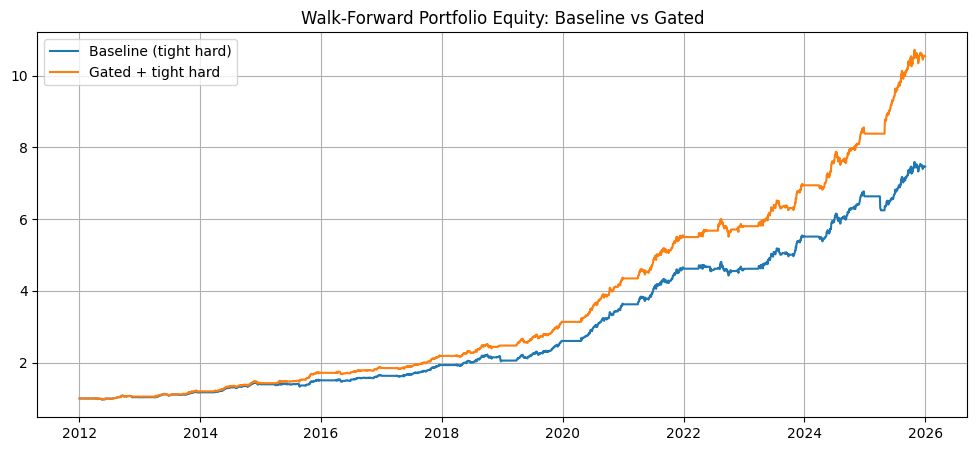

In [8]:
eq_base = (1 + port_base["portfolio_ret"]).cumprod()
eq_gated = (1 + port_gated["portfolio_ret"]).cumprod()

plt.figure(figsize=(12,5))
plt.plot(port_base["date"], eq_base, label="Baseline (tight hard)")
plt.plot(port_gated["date"], eq_gated, label="Gated + tight hard")
plt.title("Walk-Forward Portfolio Equity: Baseline vs Gated")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
def yearly_summary(portfolio_daily: pd.DataFrame, label: str) -> pd.DataFrame:
    rows = []
    for y, g in portfolio_daily.groupby("year"):
        eq = (1 + g["portfolio_ret"]).cumprod().values
        rows.append({
            "year": y,
            f"sharpe_{label}": sharpe_ratio(g["portfolio_ret"].values),
            f"ret_{label}": eq[-1] - 1.0,
            f"mdd_{label}": max_drawdown(eq),
            f"avgLev_{label}": g["portfolio_lev"].mean(),
        })
    return pd.DataFrame(rows).sort_values("year").reset_index(drop=True)

sum_base = yearly_summary(port_base, "base")
sum_gated = yearly_summary(port_gated, "gated")

compare = sum_base.merge(sum_gated, on="year", how="inner")
compare["sharpe_diff"] = compare["sharpe_gated"] - compare["sharpe_base"]
compare["mdd_diff"] = compare["mdd_gated"] - compare["mdd_base"]
compare


,year,sharpe_base,ret_base,mdd_base,avgLev_base,sharpe_gated,ret_gated,mdd_gated,avgLev_gated,sharpe_diff,mdd_diff
0,2012,0.650502,0.035983,-0.047791,0.920160,0.996072,0.052119,-0.046478,0.920160,0.345571,0.001313
1,2013,2.080086,0.130002,-0.043109,0.917379,2.179200,0.138877,-0.041252,0.914272,0.099115,0.001857
2,2014,2.751054,0.191062,-0.042818,0.924247,2.751054,0.191062,-0.042818,0.924247,0.000000,0.000000
3,2015,1.056412,0.079806,-0.066821,0.845451,2.563554,0.201627,-0.025322,0.859023,1.507142,0.041498
4,2016,1.478474,0.083897,-0.041589,0.920772,1.373083,0.077732,-0.041589,0.920772,-0.105391,0.000000
5,2017,2.703922,0.182890,-0.023836,0.919217,2.706244,0.183054,-0.023836,0.919217,0.002321,0.000000
6,2018,0.829372,0.064804,-0.086890,0.887915,1.793915,0.131363,-0.049289,0.899042,0.964543,0.037601
7,2019,3.183630,0.266496,-0.045717,0.864306,3.184404,0.267243,-0.046240,0.875832,0.000773,-0.000523
8,2020,3.907225,0.392016,-0.025602,0.737269,3.856860,0.385896,-0.025611,0.737566,-0.050365,-0.000009
9,2021,2.868887,0.274072,-0.031695,0.851948,2.795402,0.265476,-0.031695,0.853070,-0.073485,0.000000


In [11]:
def state_mix(diag: pd.DataFrame) -> pd.DataFrame:
    return (
        diag.groupby(["year", "state"]).size()
        .groupby(level=0)
        .apply(lambda x: x / x.sum())
        .rename("frac")
    )

mix_base = state_mix(diag_base)
mix_gated = state_mix(diag_gated)

mix_base.head(), mix_gated.head()


(year  year  state  
 2012  2012  CASH       0.541333
             MEANREV    0.206667
             TREND      0.252000
 2013  2013  CASH       0.431217
             MEANREV    0.088624
 Name: frac, dtype: float64,
 year  year  state  
 2012  2012  CASH       0.541333
             MEANREV    0.206667
             TREND      0.252000
 2013  2013  CASH       0.431217
             MEANREV    0.088624
 Name: frac, dtype: float64)